In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [41]:
# Find how many dates are in the file
session.query(func.count(Measurement.date)).all()

[(19550)]

In [42]:
#Find date the earlist and latest date in order to pick a date range
Beg_date = session.query(Measurement.date).order_by(Measurement.date).first()

End_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"Date Range: {Beg_date[0]}, {End_date[0]}")

Date Range: 2010-01-01, 2017-08-23


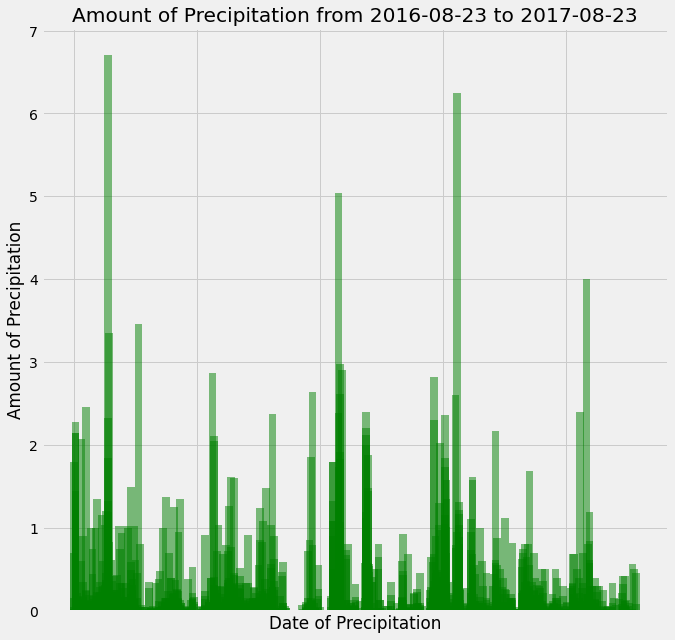

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latestdate = dt.datetime.strptime(End_date[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
Ldate = dt.date(latestdate.year - 1, latestdate.month, latestdate.day)
Ldate

# Perform a query to retrieve the data and precipitation scores
Sell = [Measurement.date,Measurement.prcp]
result = session.query(*Sell).filter(Measurement.date >= Ldate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Precp = pd.DataFrame(result, columns=['Date', 'Precipitation'])
Precp = Precp.dropna(how='any')

# Sort the dataframe by date
Precp = Precp.sort_values(["Date"], ascending=True)
Precp = Precp.set_index("Date")
Precp.head()

# Use Pandas Plotting with Matplotlib to plot the data
x = Precp.index.tolist()
y = Precp['Precipitation'].tolist()

plt.figure(figsize=(10,10))
plt.bar(x,y,width = 5, color='g', alpha=0.5, align="center", Label="Amount of Precipitation")
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
Large_ticks = np.arange(0,400,80)
plt.xticks(Large_ticks)

plt.title(f"Amount of Precipitation from {Ldate} to {End_date[0]}")
plt.xlabel("Date of Precipitation")
plt.ylabel("Amount of Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.show()


In [44]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precp.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [46]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Sell = [Measurement.station, func.count(Measurement.id)]
Active = session.query(*Sell).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
Active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [55]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Sell = [func.min(Measurement.tobs), func.max(Measurement.tobs), (func.round(func.avg(Measurement.tobs),1))]
Most_Active = session.query(*Sell).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
Most_Active

(54.0, 85.0, 71.7)

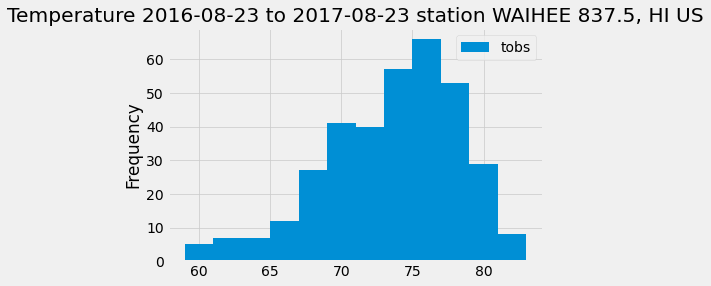

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Results = session.query(Measurement.tobs).\
    filter(Measurement.station == Active[0][0]).\
    filter(Measurement.date >= Ldate).all()
Temp = list(np.ravel(Results))

Sell = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
Results = session.query(*Sell).all()
description = pd.DataFrame(Results, columns=['Station', 'Name', 'Lat', 'Lon', 'Elev'])
S_Name = description.loc[description["Station"] == Active[0][0], "Name"].tolist()[0]

plt.hist(Temp, bins=12, rwidth=1.0, label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature {Ldate} to {End_date[0]} station {S_Name}")
plt.legend()

## Bonus Challenge Assignment

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs),1), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.6, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-03-01'
End_date = '2017-03-30'
temp_result = calc_temps(start_date, End_date)[0]
temp_result

(62.0, 72.3, 82.0)

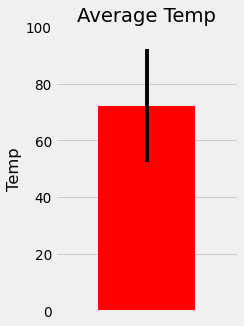

In [62]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xp = [0]
yp = [temp_result[1]]
error = [(temp_result[2] - temp_result[0])]

plt.figure(figsize=(3,5), dpi=70)
plt.bar(xp, yp, color='red', yerr=error)
plt.xlim(-0.75,0.75)
plt.title('Average Temp')
plt.ylabel('Temp')
plt.ylim(0, 100)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.grid(which='major', axis='x', linestyle=' ')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Sell = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
Result = session.query(*Sell).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= End_date).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
stations = pd.DataFrame(Result, columns=['Station', 'Name', 'Lat', 'Lon', 'Elev', 'PRCP_Sum'])
stations

,Station,Name,Lat,Lon,Elev,PRCP_Sum
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.80
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,6.79
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.93
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,3.27
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.04
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.76
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.02


In [66]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs),1), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.2, 77.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

dtobj = dt.datetime.strptime(start_date, '%Y-%m-%d')
enddtobj = dt.datetime.strptime(End_date, '%Y-%m-%d')

Trip_date = []
normals = []

while (dtobj <= enddtobj):
    Trip_date.append(dt.datetime.strftime(dtobj, '%Y-%m-%d'))
    date_string = dt.datetime.strftime(dtobj, '%m-%d')
    normals.append(list(np.ravel(daily_normals(date_string))))
    dtobj = dtobj + dt.timedelta(days = 1)
normals


[[64.0, 70.0, 76.0],
 [61.0, 70.4, 78.0],
 [60.0, 70.1, 78.0],
 [57.0, 69.3, 77.0],
 [60.0, 67.9, 76.0],
 [60.0, 69.2, 76.0],
 [60.0, 69.2, 78.0],
 [59.0, 68.7, 78.0],
 [57.0, 68.6, 75.0],
 [57.0, 69.1, 75.0],
 [60.0, 69.9, 82.0],
 [62.0, 69.9, 80.0],
 [56.0, 69.3, 77.0],
 [62.0, 70.3, 77.0],
 [58.0, 68.5, 76.0],
 [60.0, 69.7, 78.0],
 [57.0, 68.5, 75.0],
 [57.0, 67.8, 76.0],
 [60.0, 69.1, 75.0],
 [62.0, 70.1, 80.0],
 [60.0, 71.1, 77.0],
 [65.0, 71.8, 77.0],
 [63.0, 70.8, 78.0],
 [62.0, 71.5, 77.0],
 [63.0, 71.5, 78.0],
 [64.0, 71.4, 80.0],
 [63.0, 71.5, 80.0],
 [59.0, 71.5, 82.0],
 [58.0, 71.4, 77.0],
 [62.0, 72.2, 79.0]]

In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
Trip['Date'] = Trip_date
Trip = Trip.set_index("Date")
Trip

,tmin,tavg,tmax
Date,,,
2017-03-01,64.0,70.0,76.0
2017-03-02,61.0,70.4,78.0
2017-03-03,60.0,70.1,78.0
2017-03-04,57.0,69.3,77.0
2017-03-05,60.0,67.9,76.0
2017-03-06,60.0,69.2,76.0
2017-03-07,60.0,69.2,78.0
2017-03-08,59.0,68.7,78.0
2017-03-09,57.0,68.6,75.0


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 9 Text major ticklabel objects>)

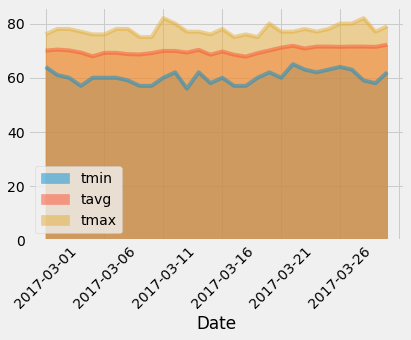

In [73]:
# Plot the daily normals as an area plot with `stacked=False`
Trip.plot.area(stacked=False)
plt.xticks(rotation=45)